In [1]:
import json
import pickle
import time
from datetime import datetime, timedelta
from itertools import product

import numpy as np
import torch
from torch.nn.utils import clip_grad_norm_
import joblib
import os

import matplotlib.pyplot as plt
from tqdm import tqdm

# Local modules
import modularised_utils as mut
import opt_utils as oput
import Linear_Additive_Noise_Models as lanm
import operations as ops
import params

np.random.seed(0)

In [2]:
experiment       = 'synth1'
abduction        = False
coeff_estimation = False

# Define the radius of the Wasserstein balls (epsilon, delta) and the size for both models.
epsilon, delta           = params.radius[experiment]
ll_num_envs, hl_num_envs = params.n_envs[experiment]

# Define the number of samples per environment. Currently every environment has the same number of samples
num_llsamples, num_hlsamples  = params.n_samples[experiment]

# Load ground truth abstraction
Tau = mut.load_T(experiment)

In [3]:
Dll_obs  = mut.load_samples(experiment)[None][0] 
Gll, Ill = mut.load_model(experiment, 'LL')
n_varsll = len(Gll.nodes())

Dhl_obs  = mut.load_samples(experiment)[None][1] 
Ghl, Ihl = mut.load_model(experiment, 'HL')
n_varshl = len(Ghl.nodes())


omega    = mut.load_omega_map(experiment)

In [4]:
if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

In [5]:
# # [Not suggested] In case we want to explore also the interventional --> worse estimation!
# Dlls, Dhls = [], []
# for dpair in list(mut.load_samples(experiment).values()):
#     Dlls.append(dpair[0])
#     Dhls.append(dpair[1])
    
# ll_coeffs = mut.get_coefficients(Dlls, Gll)
# hl_coeffs = mut.get_coefficients(Dhls, Ghl) 

In [6]:
if abduction == True:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)
else:
    U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.load_exogenous(experiment, 'LL')
    U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.load_exogenous(experiment, 'HL')

In [7]:
LLmodels = {}
for iota in Ill:
    LLmodels[iota] = lanm.LinearAddSCM(Gll, ll_coeffs, iota)
    
HLmodels, Dhl_samples = {}, {}
for eta in Ihl:
    HLmodels[eta] = lanm.LinearAddSCM(Ghl, hl_coeffs, eta)

In [8]:
def update_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L, eta):
    term1     = torch.zeros_like(mu_L)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float() 
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float() 

        term1     = term1 + V_i.T @ V_i @ mu_L.float() - V_i.T @ H_i @ mu_H.float()
    
    term2     = -2 * lambda_L * (mu_L - hat_mu_L)
    grad_mu_L = (2 / (n+1)) * term1 - term2

    return mu_L + (eta * grad_mu_L)

def update_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H, eta):

    term1     = torch.zeros_like(mu_H)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float()  
        V_i = T @ L_i  
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()  

        term1 = term1 + H_i.T @ H_i @ mu_H.float() - (V_i.T @ H_i).T @ mu_L.float()
    
    term2     = -2 * lambda_H * (mu_H - hat_mu_H)
    grad_mu_H = (2 / (n+1)) * term1 - term2

    return mu_H + (eta * grad_mu_H)


def update_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L, eta):

    term1        = torch.zeros_like(Sigma_L)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form())
        V_i = T @ L_i.float()

        term1 = term1 + V_i.T @ V_i

    Sigma_L_sqrt     = oput.sqrtm_svd(Sigma_L)  
    hat_Sigma_L_sqrt = oput.sqrtm_svd(hat_Sigma_L) 

    term2        = -2 * lambda_L * (Sigma_L_sqrt - hat_Sigma_L_sqrt) @ torch.inverse(Sigma_L_sqrt)
    grad_Sigma_L = (2 / (n+1)) * term1 - term2
    
    return Sigma_L + eta * grad_Sigma_L

def update_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H, eta):

    term1        = torch.zeros_like(Sigma_H)
    for n, iota in enumerate(Ill):
        H_i   = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()
        
        term1 = term1 + H_i.T @ H_i

    Sigma_H_sqrt     = oput.sqrtm_svd(Sigma_H)  
    hat_Sigma_H_sqrt = oput.sqrtm_svd(hat_Sigma_H) 

    term2        = -2 * lambda_H * (Sigma_H_sqrt - hat_Sigma_H_sqrt) @ torch.inverse(Sigma_H_sqrt)
    grad_Sigma_H = (2 / (n+1)) * term1 - term2

    return Sigma_H + eta * grad_Sigma_H

def update_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param):

    Sigma_L = torch.zeros_like(Sigma_L_half, dtype=torch.float32)  
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float()  
        V_i = oput.regmat(T @ L_i)  
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()  
        
        Sigma_L_half      = Sigma_L_half.float()
        V_Sigma_V         = V_i @ Sigma_L_half @ V_i.T
        sqrtm_V_Sigma_V   = oput.sqrtm_svd(oput.regmat(V_Sigma_V)) 
        prox_Sigma_L_half = oput.prox_operator(sqrtm_V_Sigma_V, lambda_param) @ oput.prox_operator(sqrtm_V_Sigma_V, lambda_param).T
        
        #ll_term_a = oput.regmat(torch.linalg.pinv(V_i)) @ oput.regmat(prox_Sigma_L_half)
        #ll_term_b = oput.regmat(torch.linalg.pinv(V_i).T)
        #ll_term   = ll_term_a @ ll_term_b
        ll_term   = oput.regmat(torch.linalg.pinv(V_i)) @ oput.regmat(prox_Sigma_L_half) @ oput.regmat(torch.linalg.pinv(V_i).T)

        Sigma_H   = Sigma_H.float()  
        H_Sigma_H = H_i @ Sigma_H @ H_i.T

        hl_term   = torch.norm(oput.sqrtm_svd(oput.regmat(H_Sigma_H)), p='fro') 

        Sigma_L = Sigma_L + (ll_term * hl_term)

    Sigma_L_final = (2 / (n+1)) * Sigma_L 
    Sigma_L_final = oput.diagonalize(Sigma_L_final)

    return Sigma_L_final

def check_for_invalid_values(matrix):
    if torch.isnan(matrix).any() or torch.isinf(matrix).any():
        #print("Matrix contains NaN or Inf values!")
        return True
    return False

def handle_nans(matrix, replacement_value=0.0):
    # Replace NaNs with a given value (default is 0)
    if torch.isnan(matrix).any():
        print("Warning: NaN values found! Replacing with zero.")
        matrix = torch.nan_to_num(matrix, nan=replacement_value)
    return matrix


def update_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param):
    Sigma_H = torch.zeros_like(Sigma_H_half)
    for n, iota in enumerate(Ill):
        L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form())
        V_i = oput.regmat(T @ L_i.float())
        H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()

        #H_Sigma_H         = oput.regmat(H_i @ Sigma_H_half @ H_i.T)
        H_Sigma_H         = H_i @ Sigma_H_half @ H_i.T
        sqrtm_H_Sigma_H   = oput.regmat(oput.sqrtm_svd(H_Sigma_H)) 

        #sqrtm_H_Sigma_H   = oput.sqrtm_svd(H_Sigma_H) 

        prox_Sigma_H_half = oput.prox_operator(sqrtm_H_Sigma_H, lambda_param) @ oput.prox_operator(sqrtm_H_Sigma_H, lambda_param).T
        #hl_term           = torch.inverse(H_i) @ prox_Sigma_H_half @ torch.inverse(H_i).T
        hl_term           = H_i @ prox_Sigma_H_half @ H_i.T
        
        V_Sigma_V = V_i @ Sigma_L @ V_i.T
        ll_term   = torch.norm(oput.sqrtm_svd(oput.regmat(V_Sigma_V)))

        Sigma_H = Sigma_H + (ll_term * hl_term)
    
    Sigma_H_final = (2 / (n+1)) * Sigma_H
    Sigma_H_final = oput.diagonalize(Sigma_H_final)
    
    return Sigma_H_final

In [9]:
def optimize_max(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, lambda_L, lambda_H, lambda_param, eta, num_steps_max, epsilon, delta, seed):
    
    torch.manual_seed(seed)
    for t in range(num_steps_max): 
        mu_L         = update_mu_L(T, mu_L, mu_H, LLmodels, HLmodels, lambda_L, hat_mu_L, eta)
        mu_H         = update_mu_H(T, mu_L, mu_H, LLmodels, HLmodels, lambda_H, hat_mu_H, eta)
        Sigma_L_half = update_Sigma_L_half(T, Sigma_L, LLmodels, lambda_L, hat_Sigma_L, eta)
        Sigma_L      = update_Sigma_L(T, Sigma_L_half, LLmodels, Sigma_H, HLmodels, lambda_param)
        
        Sigma_H_half = update_Sigma_H_half(T, Sigma_H, HLmodels, lambda_H, hat_Sigma_H, eta)
        
        Sigma_H      = update_Sigma_H(T, Sigma_H_half, LLmodels, Sigma_L, HLmodels, lambda_param)
        
        # Project onto Gelbrich balls
        mu_L, Sigma_L = oput.project_onto_gelbrich_ball(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        mu_H, Sigma_H = oput.project_onto_gelbrich_ball(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        # Verify constraints
        satisfied_L, dist_L, epsi = oput.verify_gelbrich_constraint(mu_L, Sigma_L, hat_mu_L, hat_Sigma_L, epsilon)
        satisfied_H, dist_H, delt = oput.verify_gelbrich_constraint(mu_H, Sigma_H, hat_mu_H, hat_Sigma_H, delta)
        
        if not satisfied_L:
            print(f"Warning: Constraints not satisfied for mu_L and Sigma_L! Distance: {dist_L} and epsilon = {epsi}")

        if not satisfied_H:
            print(f"Warning: Constraints not satisfied for mu_H and Sigma_H! Distance: {dist_H} and delta = {delt}")
        
        obj = 0
        
        for i, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form())
            V_i = T @ L_i.float()
            H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()
                        
            L_i_mu_L = V_i @ mu_L
            H_i_mu_H = H_i @ mu_H
            term1 = torch.norm(L_i_mu_L.float() - H_i_mu_H.float())**2
            
            V_Sigma_V = oput.regmat(V_i.float() @ Sigma_L.float() @ V_i.T.float())
            H_Sigma_H = oput.regmat(H_i.float() @ Sigma_H.float() @ H_i.T.float())
            
            term2 = torch.trace(V_Sigma_V)
            term3 = torch.trace(H_Sigma_H)
            
            sqrtVSV = oput.sqrtm_svd(V_Sigma_V)
            sqrtHSH = oput.sqrtm_svd(H_Sigma_H)

            term4 = -2 * torch.trace(oput.sqrtm_svd(oput.regmat(sqrtVSV @ sqrtHSH @ sqrtVSV)))

            obj = obj + (term1 + term2 + term3 + term4)
        
        obj = obj/(i+1)
        #print(f"Max step {t+1}/{num_steps_max}, Objective: {obj.item()}")

    return obj, mu_L, Sigma_L, mu_H, Sigma_H


def optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, num_steps_min, optimizer_T, seed):

    torch.manual_seed(seed)
    T = torch.nn.init.xavier_normal_(T, gain=0.01)
    objective_T = torch.tensor(0.0)  # Initialize as tensor instead of int 
    for step in range(num_steps_min):
        objective_T = torch.tensor(0.0) # Reset objective at the start of each step
        for n, iota in enumerate(Ill):
            L_i = torch.from_numpy(LLmodels[iota]._compute_reduced_form()).float()
            H_i = torch.from_numpy(HLmodels[omega[iota]]._compute_reduced_form()).float()
            
            L_i_mu_L = L_i @ mu_L  
            H_i_mu_H = H_i @ mu_H 

            term1 = torch.norm(T @ L_i_mu_L - H_i_mu_H) ** 2
            term2 = torch.trace(T @ L_i @ Sigma_L @ L_i.T @ T.T)
            term3 = torch.trace(H_i @ Sigma_H @ H_i.T)
            
            L_i_Sigma_L = oput.regmat(T @ L_i @ Sigma_L @ L_i.T @ T.T)
            H_i_Sigma_H = oput.regmat(H_i @ Sigma_H @ H_i.T)

            L_i_Sigma_L = T @ L_i @ Sigma_L @ L_i.T @ T.T
            H_i_Sigma_H = H_i @ Sigma_H @ H_i.T
            #term4 = -2 * torch.norm(oput.sqrtm_svd(L_i_Sigma_L) @ oput.sqrtm_svd(H_i_Sigma_H), 'nuc')
            term4 = -2 * torch.trace(oput.sqrtm_svd(oput.sqrtm_svd(L_i_Sigma_L) @ H_i_Sigma_H @ oput.sqrtm_svd(L_i_Sigma_L)))

            objective_T = objective_T + term1 + term2 + term3 + term4
            
        objective_T = objective_T/(n+1)
        # print(f"obgective value at the end of step {step} = {objective_T}")
        # print(f"current T at step {step}: {T}")
        # print('T.grad', T.grad) 
        if torch.isnan(T).any():
            print("Gradient contains NaN!")
            print('step: ', step+1)

        optimizer_T.zero_grad() 
        objective_T.backward(retain_graph=True) 
        optimizer_T.step()            
        
        #print(f"Min step {step+1}/{num_steps_min}, Objective: {objective_T.item()}")


    return objective_T, T 

In [10]:
# def run_optimization(mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, 
#                      hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H, 
#                      epsilon, delta, lambda_L, lambda_H, lambda_param, 
#                      eta_min, eta_max, max_iter, num_steps_min, num_steps_max, tol, seed, robust):
#     torch.manual_seed(seed) 
#     torch.cuda.manual_seed_all(seed)

#     if robust == False:
#         epsilon = 0.0
#         delta   = 0.0

#     T = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)
    
#     optimizer_T = torch.optim.Adam([T], lr=1e-5, eps=1e-8, amsgrad=True)
    
#     #optimizer_T = torch.optim.Adam([T], lr=1e-5)
#     #optimizer_T        = torch.optim.SGD([T], lr=1e-5, momentum=0.9)
#     previous_objective = float('inf')  
#     for epoch in tqdm(range(max_iter)): 

#         # ---- Minimize T ----
#         print(f"Before optimize_min, T: {T}")
#         objective_T, T = optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, num_steps_min, optimizer_T, seed)
#         print(f"After optimize_min, T: {T}")

#         # ---- Maximize mu_L, Sigma_L, mu_H, Sigma_H ----
#         if robust == True:
           
#             obj_theta, mu_L, Sigma_L, mu_H, Sigma_H = optimize_max(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
#                                                         hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
#                                                         lambda_L, lambda_H, lambda_param, eta_max, num_steps_max,
#                                                         epsilon, delta, seed)
#         print( )
       
#         criterion = abs(previous_objective - objective_T.item()) 
        
#         if criterion < tol:
#             print(f"Convergence reached at epoch {epoch+1} with objective {objective_T.item()}")
#             break

#         previous_objective = objective_T.item()

#     print("Final T:", T)
#     print("Final mu_L:", mu_L)
#     print("Final Sigma_L:", Sigma_L)
#     print("Final mu_H:", mu_H)
#     print("Final Sigma_H:", Sigma_H)
#     print('Final T: ', T)

#     return mu_L, Sigma_L, mu_H, Sigma_H, T

In [15]:
def run_optimization(theta_hatL, theta_hatH, initial_theta,
                     epsilon, delta, lambda_L, lambda_H, lambda_param, 
                     eta_min, eta_max, max_iter, num_steps_min, num_steps_max, tol, seed, robust, plot_steps, plot_epochs):
    
    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)

    hat_mu_L, hat_Sigma_L = torch.from_numpy(theta_hatL['mu_U']).float(), torch.from_numpy(theta_hatL['Sigma_U']).float()
    hat_mu_H, hat_Sigma_H = torch.from_numpy(theta_hatH['mu_U']).float(), torch.from_numpy(theta_hatH['Sigma_U']).float()

    if initial_theta == 'gelbrich':
        l = hat_mu_L.shape[0]
        h = hat_mu_H.shape[0]

        # Gelbrich initialization
        ll_moments      = mut.sample_moments_U(mu_hat = theta_hatL['mu_U'], Sigma_hat = theta_hatL['Sigma_U'], bound = epsilon, num_envs = 1)
        mu_L, Sigma_L = ll_moments[0]
        mu_L, Sigma_L = torch.from_numpy(mu_L).float(), torch.from_numpy(Sigma_L).float()

        hl_moments      = mut.sample_moments_U(mu_hat = theta_hatH['mu_U'], Sigma_hat = theta_hatH['Sigma_U'], bound = delta, num_envs = 1)
        mu_H, Sigma_H = hl_moments[0]
        mu_H, Sigma_H = torch.from_numpy(mu_H).float(), torch.from_numpy(Sigma_H).float()
        
    elif initial_theta == 'empirical':
        mu_L, Sigma_L = hat_mu_L, hat_Sigma_L
        mu_H, Sigma_H = hat_mu_H, hat_Sigma_H
    
    # Initialize storage
    epoch_objectives      = {'T_objectives': [], 'theta_objectives': []}
    inner_loop_objectives = {'min_objectives': [], 'max_objectives': []}

    if not robust:
        epsilon = delta = 0.0

    T = torch.randn(mu_H.shape[0], mu_L.shape[0], requires_grad=True)
    optimizer_T = torch.optim.Adam([T], lr=1e-5, eps=1e-8, amsgrad=True)
    
    previous_objective = float('inf')  
    for epoch in tqdm(range(max_iter)): 
        epoch_min_objectives = []  
        epoch_max_objectives = []  

        # Minimize T
        for min_step in range(num_steps_min):
            objective_T, T = optimize_min(T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels, 1, optimizer_T, seed)
            epoch_min_objectives.append(objective_T.item())

        # Maximize parameters if robust
        final_obj_theta = None
        if robust:
            for max_step in range(num_steps_max):
                obj_theta, mu_L, Sigma_L, mu_H, Sigma_H = optimize_max(
                    T, mu_L, Sigma_L, mu_H, Sigma_H, LLmodels, HLmodels,
                    hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                    lambda_L, lambda_H, lambda_param, eta_max, 1,
                    epsilon, delta, seed
                )
                epoch_max_objectives.append(obj_theta.item())
                final_obj_theta = obj_theta.item()

        # Store objectives
        inner_loop_objectives['min_objectives'].append(epoch_min_objectives)
        inner_loop_objectives['max_objectives'].append(epoch_max_objectives)
        epoch_objectives['T_objectives'].append(objective_T.item())
        if final_obj_theta is not None:
            epoch_objectives['theta_objectives'].append(final_obj_theta)

        # Plot progress
        if plot_steps == True:
            oput.plot_epoch_progress(epoch, epoch_min_objectives, epoch_max_objectives, robust)

        # Check convergence
        criterion = abs(previous_objective - objective_T.item()) 
        if criterion < tol:
            print(f"Convergence reached at epoch {epoch+1} with objective {objective_T.item()}")
            break

        previous_objective = objective_T.item()

    # Plot overall progress
    if plot_epochs == True:
        oput.plot_overall_progress(epoch_objectives, robust)

    # Print final values
    print("Final T:", T)
    print("Final mu_L:", mu_L)
    print("Final Sigma_L:", Sigma_L)
    print("Final mu_H:", mu_H)
    print("Final Sigma_H:", Sigma_H)

    paramsL = {'mu_U': mu_L.detach().numpy(), 'Sigma_U': Sigma_L.detach().numpy(), 'radius': epsilon}
    paramsH = {'mu_U': mu_H.detach().numpy(), 'Sigma_U': Sigma_H.detach().numpy(), 'radius': delta}

    T = T.detach().numpy()
    
    return paramsL, paramsH, T, inner_loop_objectives, epoch_objectives

### ERICA optimization

In [19]:
theta_hatL   = {'mu_U': mu_U_ll_hat, 'Sigma_U': Sigma_U_ll_hat, 'radius': epsilon}
theta_hatH   = {'mu_U': mu_U_hl_hat, 'Sigma_U': Sigma_U_hl_hat, 'radius': delta}

params_erica =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': 0.9,
                    'delta': 0.8,
                    'lambda_L': 0.9,
                    'lambda_H': 0.9,
                    'lambda_param': 0.9,
                    'eta_max': 0.001,
                    'eta_min': 0.0001,
                    'max_iter': 10,
                    'num_steps_min': 3,
                    'num_steps_max': 2,
                    'tol': 1e-8,
                    'seed': 0,
                    'robust': True,
                    'plot_steps': False,
                    'plot_epochs': False
                }

In [20]:
params_Lerica, params_Herica, T_erica, inobjs, epobjs = run_optimization(**params_erica)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:00,  9.87it/s]

 20%|██        | 2/10 [00:00<00:01,  7.31it/s]

 30%|███       | 3/10 [00:00<00:01,  5.34it/s]

 30%|███       | 3/10 [00:00<00:01,  3.54it/s]

Convergence reached at epoch 4 with objective 8.371601104736328
Final T: tensor([[ 0.0098, -0.0019, -0.0138],
        [ 0.0036, -0.0069, -0.0089]], requires_grad=True)
Final mu_L: tensor([-2.8298e-07,  1.9673e-08,  4.0886e-07], grad_fn=<AddBackward0>)
Final Sigma_L: tensor([[0.3218, 0.0000, 0.0000],
        [0.0000, 0.5835, 0.0000],
        [0.0000, 0.0000, 0.3059]], grad_fn=<MmBackward0>)
Final mu_H: tensor([0.0163, 0.0008], grad_fn=<AddBackward0>)
Final Sigma_H: tensor([[8.2023, 0.0000],
        [0.0000, 0.2016]], grad_fn=<MmBackward0>)


### ENRiCO optimization

In [23]:
theta_hatL   = {'mu_U': mu_U_ll_hat, 'Sigma_U': Sigma_U_ll_hat, 'radius': epsilon}
theta_hatH   = {'mu_U': mu_U_hl_hat, 'Sigma_U': Sigma_U_hl_hat, 'radius': delta}

params_enrico =  {
                    'theta_hatL': theta_hatL,
                    'theta_hatH': theta_hatH,
                    'initial_theta': 'empirical',
                    'epsilon': 0.9,
                    'delta': 0.8,
                    'lambda_L': 0.9,
                    'lambda_H': 0.9,
                    'lambda_param': 0.9,
                    'eta_max': 0.001,
                    'eta_min': 0.0001,
                    'max_iter': 10,
                    'num_steps_min': 3,
                    'num_steps_max': 2,
                    'tol': 1e-8,
                    'seed': 0,
                    'robust': False,
                    'plot_steps': False,
                    'plot_epochs': False
                }

In [24]:
params_Lenrico, params_Henrico, T_enrico, inobjs, epobjs = run_optimization(**params_enrico)

  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:00<00:01,  8.12it/s]

Convergence reached at epoch 2 with objective 13.585732460021973
Final T: tensor([[ 0.0098, -0.0019, -0.0138],
        [ 0.0036, -0.0069, -0.0089]], requires_grad=True)
Final mu_L: tensor([0., 0., 0.])
Final Sigma_L: tensor([[1., 0., 0.],
        [0., 2., 0.],
        [0., 0., 1.]])
Final mu_H: tensor([0.0163, 0.0008])
Final Sigma_H: tensor([[13.3758,  0.0000],
        [ 0.0000,  0.3048]])


In [ ]:
# # Save results
# np.save('T_erica.npy', T_erica)
# np.save('T_enrico.npy', T_enrico)
# np.save('Tau.npy', Tau)

# # Load results
# T_erica = np.load('T_erica.npy')
# T_enrico = np.load('T_enrico.npy')
# Tau = np.load('Tau.npy')


In [33]:
print('T_erica condition number = ', oput.condition_number(T_erica))
print('T_enrico condition number = ', oput.condition_number(T_enrico))
print('Ground truth Tau condition number = ', oput.condition_number(Tau))

T_erica condition number =  3.7877681
T_enrico condition number =  3.787791
Ground truth Tau condition number =  4.738720018687272


## Run Evaluation

In [19]:
data = mut.load_samples(experiment)

In [ ]:
ll_noisy = True
hl_noisy = False
num_iter = 100

In [30]:
def add_random_noise(data, noise_type, params_theta=None, params_erica=None):

    num_samples = data.shape[0]

    if noise_type == 'gelbrich':
        mu_U_hat    = params_theta['mu_U']
        Sigma_U_hat = params_theta['Sigma_U']
        radius      = params_theta['radius']
        moments     = mut.sample_moments_U(mu_hat = mu_U_hat, Sigma_hat = Sigma_U_hat, bound = radius, num_envs = 1)
        
        noise_mu, noise_Sigma = moments[0]

    if noise_type == 'max':
        noise_mu, noise_Sigma = params_erica['mu_U'], params_erica['Sigma_U']

    noise = np.random.multivariate_normal(mean=noise_mu, cov=noise_Sigma, size=num_samples)

    return data + noise

In [47]:
for i, T in enumerate([T_erica, T_enrico, Tau]): 
    avg_moms = 0
    avg_distros = 0
    for _ in range(num_iter):
        tot_moms = 0
        tot_distros = 0
        for iota in Ill:
            base, abst = data[iota]
            if ll_noisy == True:
                base = add_random_noise(base, 'gelbrich', theta_hatL)
            if hl_noisy == True:
                abst = add_random_noise(abst, 'gelbrich', theta_hatH)

            tau_base = base@T.T

            tau_muL    = np.mean(tau_base, axis=0)
            tau_sigmaL = np.cov(tau_base, rowvar=False)
            muH        = np.mean(abst, axis=0)
            sigmaH     = np.cov(abst, rowvar=False)

            dist_moms  = mut.wasserstein_moments(tau_muL, tau_sigmaL, muH, sigmaH)

            tau_gaussian  = mut.sample_distros_Gelbrich([(tau_muL, tau_sigmaL)])[0] 
            abst_gaussian = mut.sample_distros_Gelbrich([(muH, sigmaH)])[0] 

            dist_distros  = mut.wasserstein_dist(tau_gaussian, abst_gaussian)
            
            tot_moms    += dist_moms
            tot_distros += dist_distros


        avg_moms += tot_moms/len(Ill)
        avg_distros += tot_distros/len(Ill)

    print(f"Average moments {i+1}: {avg_moms/100}")
    print(f"Average distros {i+1}: {avg_distros/100}")

Average AE 1: 15.309100157607176
Average AE 2: 15.308981822056193
Average AE 3: 1.5793264168391565


Original correlations:
[[1.         0.19355199 0.06702295]
 [0.19355199 1.         0.29778543]
 [0.06702295 0.29778543 1.        ]]

Contaminated correlations:
[[1.         0.17113081 0.05988528]
 [0.17113081 1.         0.28023058]
 [0.05988528 0.28023058 1.        ]]


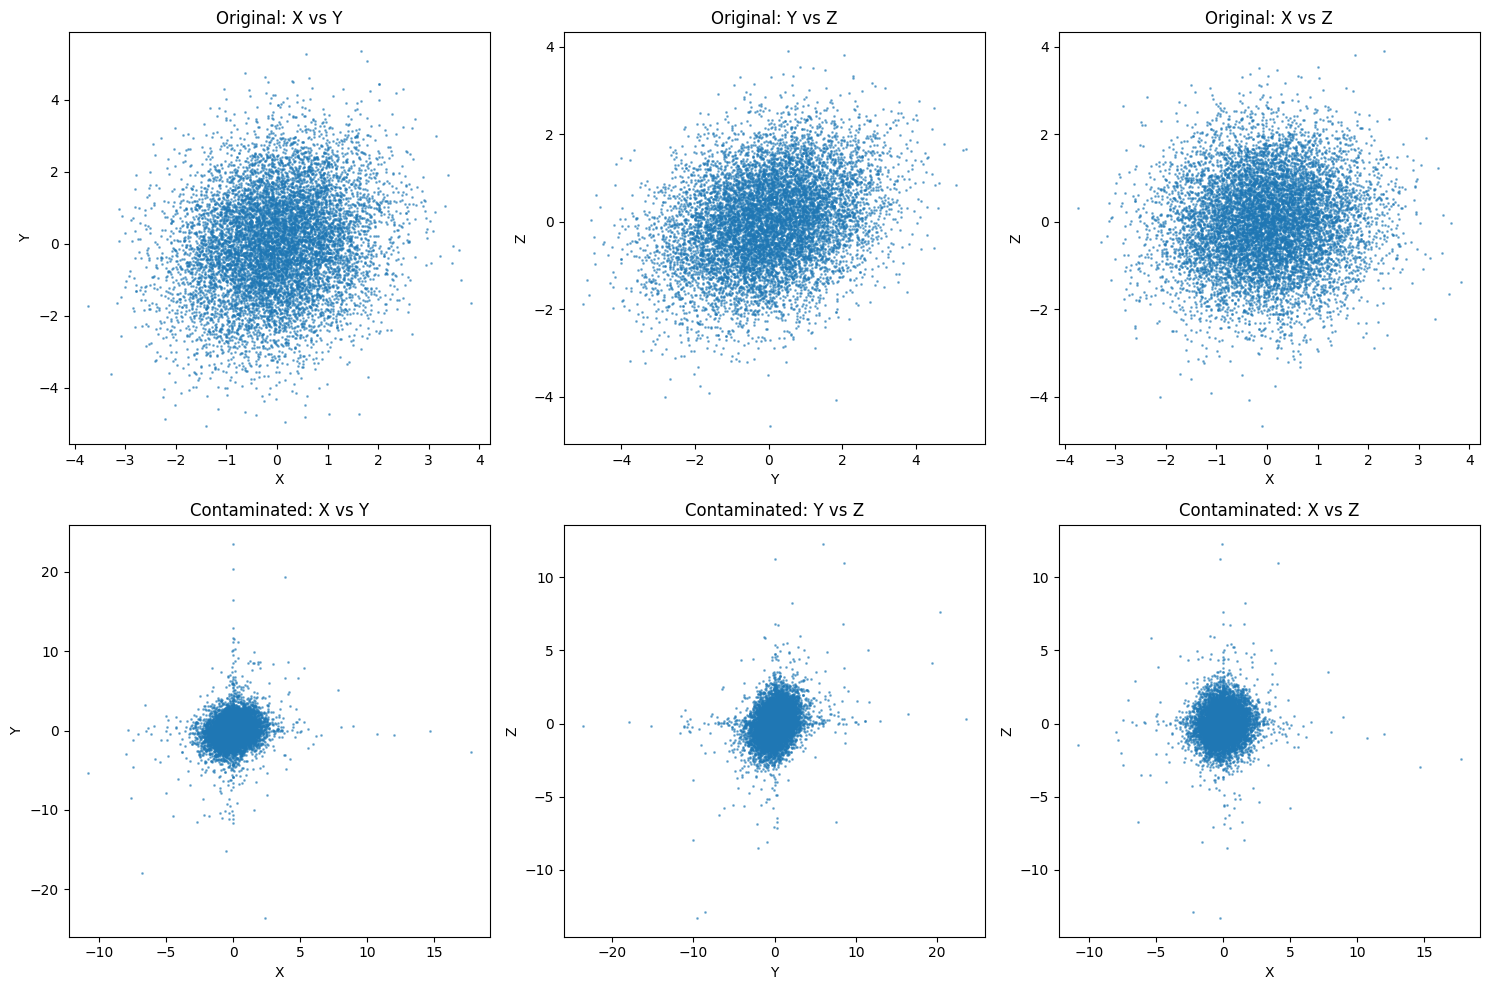

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Create synthetic causal data (linear relationships)
np.random.seed(42)  # for reproducibility
n_samples = 1000

# Generate X (first variable)
X = np.random.normal(0, 1, n_samples)

# Generate Y (depends on X)
Y = 0.5 * X + np.random.normal(0, 0.1, n_samples)

# Generate Z (depends on Y)
Z = 0.7 * Y + np.random.normal(0, 0.1, n_samples)

# Combine into one array
original_data = Dll

def contaminate_causal_data(data, nonlinear_fraction=0.3, noise_level=0.1):
    """
    Contaminate causal data by adding noise and non-linear transformations.
    """
    contaminated_data = data.copy()
    n_samples = data.shape[0]
    
    # Add base noise
    noise = np.random.normal(0, noise_level, data.shape)
    contaminated_data += noise
    
    # Select random subset for non-linear transformations
    n_contaminate = int(n_samples * nonlinear_fraction)
    indices_to_contaminate = np.random.choice(n_samples, n_contaminate, replace=False)
    
    for idx in indices_to_contaminate:
        transform_type = np.random.choice(['quadratic', 'exponential', 'sinusoidal'])
        
        if transform_type == 'quadratic':
            contaminated_data[idx] = contaminated_data[idx]**2 * np.sign(contaminated_data[idx])
        elif transform_type == 'exponential':
            contaminated_data[idx] = np.exp(contaminated_data[idx] * 0.5) - 1
        elif transform_type == 'sinusoidal':
            contaminated_data[idx] = np.sin(contaminated_data[idx])
    
    return contaminated_data

def plot_relationships(original, contaminated):
    """Plot relationships between variables"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original data relationships
    axes[0,0].scatter(original[:,0], original[:,1], alpha=0.5, s=1)
    axes[0,0].set_title('Original: X vs Y')
    axes[0,0].set_xlabel('X'); axes[0,0].set_ylabel('Y')
    
    axes[0,1].scatter(original[:,1], original[:,2], alpha=0.5, s=1)
    axes[0,1].set_title('Original: Y vs Z')
    axes[0,1].set_xlabel('Y'); axes[0,1].set_ylabel('Z')
    
    axes[0,2].scatter(original[:,0], original[:,2], alpha=0.5, s=1)
    axes[0,2].set_title('Original: X vs Z')
    axes[0,2].set_xlabel('X'); axes[0,2].set_ylabel('Z')
    
    # Contaminated data relationships
    axes[1,0].scatter(contaminated[:,0], contaminated[:,1], alpha=0.5, s=1)
    axes[1,0].set_title('Contaminated: X vs Y')
    axes[1,0].set_xlabel('X'); axes[1,0].set_ylabel('Y')
    
    axes[1,1].scatter(contaminated[:,1], contaminated[:,2], alpha=0.5, s=1)
    axes[1,1].set_title('Contaminated: Y vs Z')
    axes[1,1].set_xlabel('Y'); axes[1,1].set_ylabel('Z')
    
    axes[1,2].scatter(contaminated[:,0], contaminated[:,2], alpha=0.5, s=1)
    axes[1,2].set_title('Contaminated: X vs Z')
    axes[1,2].set_xlabel('X'); axes[1,2].set_ylabel('Z')
    
    plt.tight_layout()
    plt.show()

# Contaminate the data
contaminated_data = contaminate_causal_data(
    original_data,
    nonlinear_fraction=0.3,  # 30% of points will have non-linear transformations
    noise_level=0.2         # Amount of random noise
)

# Print correlations
print("Original correlations:")
print(np.corrcoef(original_data.T))
print("\nContaminated correlations:")
print(np.corrcoef(contaminated_data.T))

# Plot the relationships
plot_relationships(original_data, contaminated_data)

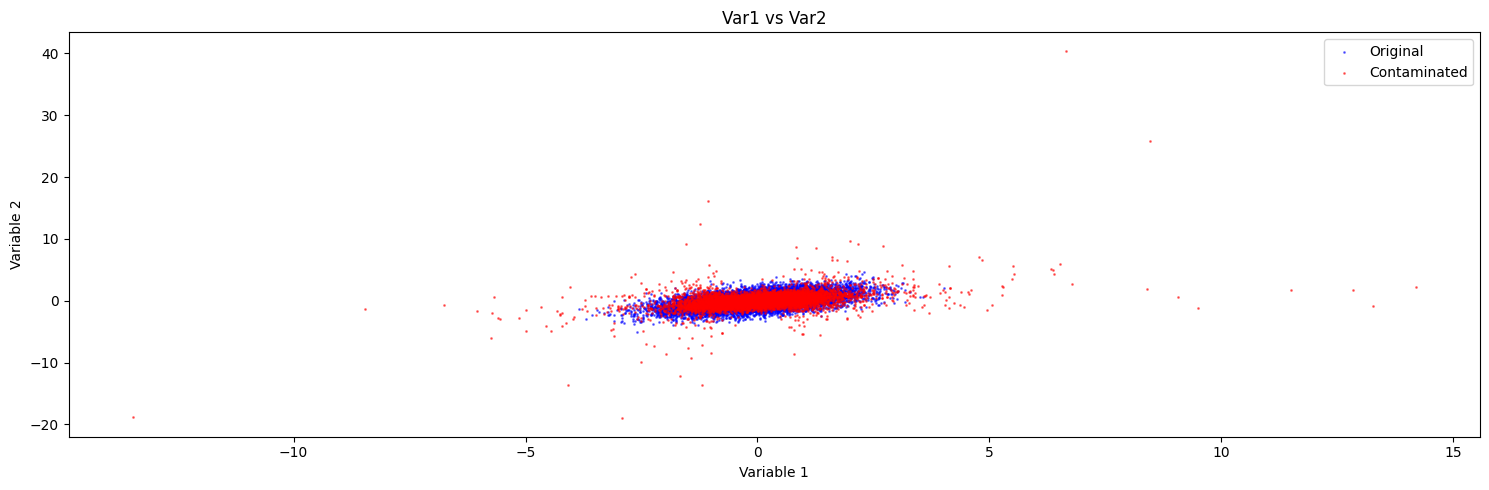

In [96]:
def contaminate_linear_relationships(data, contamination_fraction=0.3):
    """
    Contaminate linear relationships by applying non-linear transformations
    and introducing non-additive noise.
    
    Args:
        data: numpy array of shape (n_samples, n_vars) from linear additive model
        contamination_fraction: fraction of data to contaminate
    
    Returns:
        Contaminated data array
    """
    contaminated = data.copy()
    n_samples, n_vars = data.shape
    
    # Select samples to contaminate
    n_contaminate = int(n_samples * contamination_fraction)
    contaminate_idx = np.random.choice(n_samples, n_contaminate, replace=False)
    
    # Different types of contamination
    for idx in contaminate_idx:
        # Randomly choose contamination type
        contamination_type = np.random.choice([
            'multiplicative_interaction',  # Multiply variables together
            'threshold_effect',           # Create discontinuous relationships
            'exponential_scaling',        # Exponential relationships
            'cross_variable_mixing'       # Mix information between variables
        ])
        
        if contamination_type == 'multiplicative_interaction':
            # Multiply pairs of variables
            for i in range(n_vars-1):
                contaminated[idx, i+1] *= contaminated[idx, i]
                
        elif contamination_type == 'threshold_effect':
            # Create discontinuous jumps
            thresholds = np.random.randn(n_vars)
            for i in range(n_vars):
                if contaminated[idx, i] > thresholds[i]:
                    contaminated[idx, i] *= 2
                else:
                    contaminated[idx, i] *= 0.5
                    
        elif contamination_type == 'exponential_scaling':
            # Create exponential relationships
            for i in range(n_vars):
                sign = np.sign(contaminated[idx, i])
                contaminated[idx, i] = sign * np.exp(np.abs(contaminated[idx, i]))
                
        elif contamination_type == 'cross_variable_mixing':
            # Mix information between variables
            mix_matrix = np.random.randn(n_vars, n_vars)
            contaminated[idx] = contaminated[idx] @ mix_matrix
    
    # Normalize to keep similar scale as original data
    for i in range(n_vars):
        orig_std = np.std(data[:, i])
        orig_mean = np.mean(data[:, i])
        contaminated[:, i] = (contaminated[:, i] - np.mean(contaminated[:, i])) / np.std(contaminated[:, i])
        contaminated[:, i] = contaminated[:, i] * orig_std + orig_mean
    
    return contaminated

# Example usage:
# contaminated_data = contaminate_linear_relationships(data, contamination_fraction=0.3)

def plot_contamination_effect(original, contaminated):
    """Visualize the effect of contamination"""
    n_vars = original.shape[1]
    
    plt.figure(figsize=(15, 5))
    
    # Plot original vs contaminated for each pair of variables
    for i in range(n_vars-1):
        plt.subplot(1, n_vars-1, i+1)
        
        # Plot original
        plt.scatter(original[:, i], original[:, i+1], 
                   alpha=0.5, s=1, label='Original', color='blue')
        
        # Plot contaminated
        plt.scatter(contaminated[:, i], contaminated[:, i+1], 
                   alpha=0.5, s=1, label='Contaminated', color='red')
        
        plt.xlabel(f'Variable {i+1}')
        plt.ylabel(f'Variable {i+2}')
        plt.title(f'Var{i+1} vs Var{i+2}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

# Usage:
data = Dhl
contaminated = contaminate_linear_relationships(data, contamination_fraction=0.3)
plot_contamination_effect(data, contaminated)

=== Noise Analysis ===

Variable 1:
Original mean: 0.009
Noisy mean: 0.029
Original std: 1.002
Noisy std: 2.830
Missing values: 505

Variable 2:
Original mean: -0.003
Noisy mean: 0.014
Original std: 1.154
Noisy std: 3.829
Missing values: 475


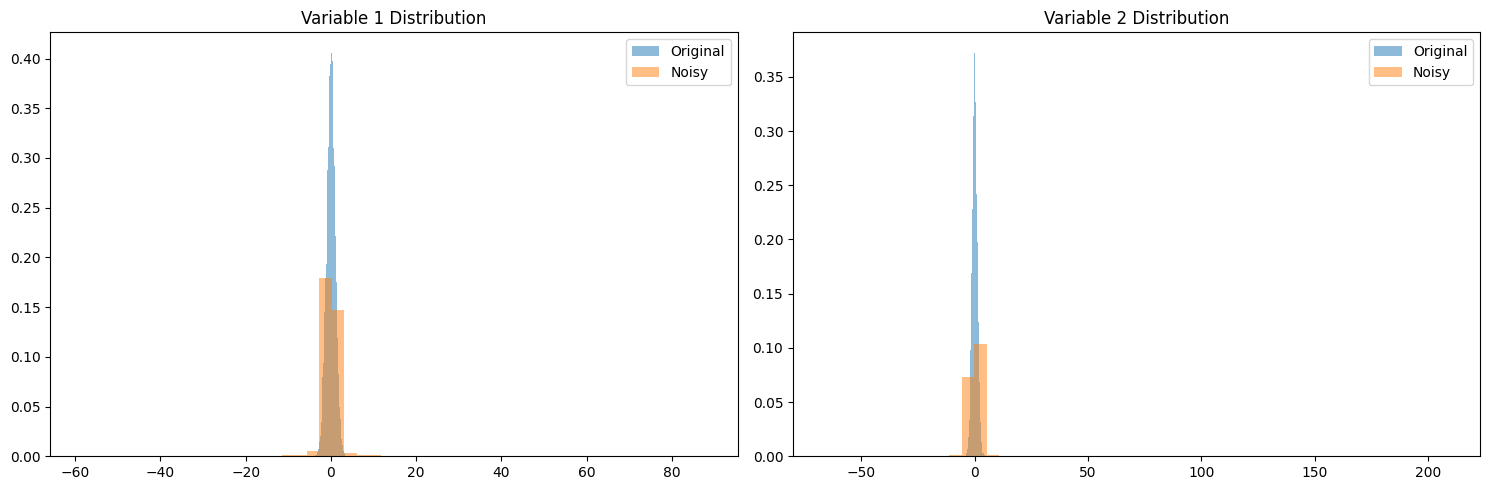

In [102]:
def add_noise_to_dataset(data, noise_config=None):
    """
    Add different types of noise to make a dataset dirty.
    
    Args:
        data: numpy array of shape (n_samples, n_vars)
        noise_config: dictionary with noise parameters
            - gaussian_noise: std of Gaussian noise
            - outlier_fraction: fraction of outliers to add
            - missing_fraction: fraction of values to set as missing (NaN)
            - swap_fraction: fraction of values to swap between samples
    
    Returns:
        Noisy data array
    """
    if noise_config is None:
        noise_config = {
            'gaussian_noise': 0.1,      # Standard deviation of Gaussian noise
            'outlier_fraction': 0.01,   # 1% outliers
            'missing_fraction': 0.05,   # 5% missing values
            'swap_fraction': 0.02       # 2% swapped values
        }
    
    noisy_data = data.copy()
    n_samples, n_vars = data.shape
    
    # 1. Add Gaussian noise
    if noise_config['gaussian_noise'] > 0:
        noise = np.random.normal(0, noise_config['gaussian_noise'], 
                               size=data.shape)
        noisy_data += noise
    
    # 2. Add outliers
    if noise_config['outlier_fraction'] > 0:
        n_outliers = int(n_samples * n_vars * noise_config['outlier_fraction'])
        # Randomly select positions for outliers
        outlier_rows = np.random.randint(0, n_samples, size=n_outliers)
        outlier_cols = np.random.randint(0, n_vars, size=n_outliers)
        
        # Create outliers by multiplying with large random values
        for row, col in zip(outlier_rows, outlier_cols):
            multiplier = np.random.choice([-1, 1]) * np.random.uniform(3, 10)
            noisy_data[row, col] *= multiplier
    
    # 3. Add missing values (NaN)
    if noise_config['missing_fraction'] > 0:
        n_missing = int(n_samples * n_vars * noise_config['missing_fraction'])
        missing_rows = np.random.randint(0, n_samples, size=n_missing)
        missing_cols = np.random.randint(0, n_vars, size=n_missing)
        noisy_data[missing_rows, missing_cols] = np.nan
    
    # 4. Swap values between samples
    if noise_config['swap_fraction'] > 0:
        n_swaps = int(n_samples * n_vars * noise_config['swap_fraction'])
        for _ in range(n_swaps):
            # Select two random positions
            row1, row2 = np.random.randint(0, n_samples, size=2)
            col = np.random.randint(0, n_vars)
            # Swap values
            noisy_data[row1, col], noisy_data[row2, col] = \
                noisy_data[row2, col], noisy_data[row1, col]
    
    return noisy_data

def analyze_noise_effects(original, noisy):
    """
    Analyze and visualize the effects of added noise.
    """
    n_vars = original.shape[1]
    
    # Print basic statistics
    print("=== Noise Analysis ===")
    for i in range(n_vars):
        print(f"\nVariable {i+1}:")
        print(f"Original mean: {np.nanmean(original[:, i]):.3f}")
        print(f"Noisy mean: {np.nanmean(noisy[:, i]):.3f}")
        print(f"Original std: {np.nanstd(original[:, i]):.3f}")
        print(f"Noisy std: {np.nanstd(noisy[:, i]):.3f}")
        print(f"Missing values: {np.sum(np.isnan(noisy[:, i]))}")
        
    # Visualize distributions
    plt.figure(figsize=(15, 5))
    for i in range(n_vars):
        plt.subplot(1, n_vars, i+1)
        plt.hist(original[:, i], bins=50, alpha=0.5, label='Original', 
                density=True)
        plt.hist(noisy[:, i][~np.isnan(noisy[:, i])], bins=50, alpha=0.5, 
                label='Noisy', density=True)
        plt.title(f'Variable {i+1} Distribution')
        plt.legend()
    plt.tight_layout()
    plt.show()

# Example usage:
noise_config = {
    'gaussian_noise': 0.6,      # Add Gaussian noise with std=0.1
    'outlier_fraction': 0.05,   # Add 1% outliers
    'missing_fraction': 0.05,   # Make 5% of values missing
    'swap_fraction': 0.02       # Swap 2% of values between samples
}

dirty_data = add_noise_to_dataset(data, noise_config)
analyze_noise_effects(data, dirty_data)

In [99]:
# First contaminate linear relationships
contaminated_data = contaminate_linear_relationships(data, contamination_fraction=0.3)

# Then add noise to make it dirty
dirty_data = add_noise_to_dataset(contaminated_data, noise_config)

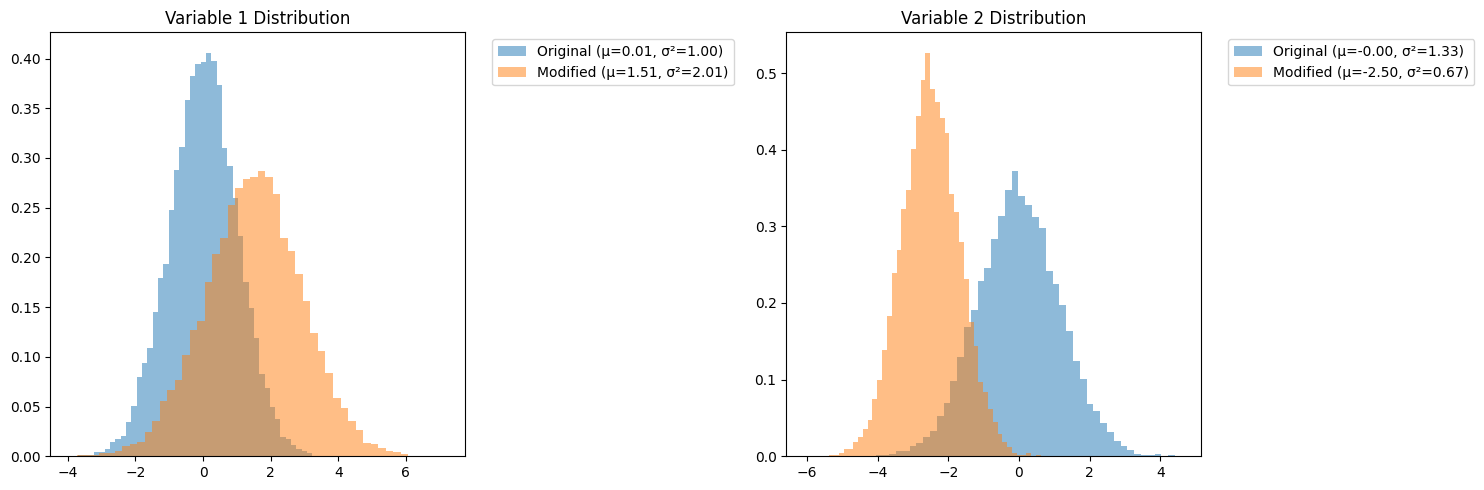

In [107]:
def shift_gaussian_distribution(data, mean_shift=None, var_multiplier=None):
    """
    Shift and scale a Gaussian distribution by modifying its mean and variance.
    
    Args:
        data: numpy array of shape (n_samples, n_vars)
        mean_shift: dict of shifts for each variable, e.g., {0: 1.5, 2: -0.5}
                   (if None, no shift is applied)
        var_multiplier: dict of variance multipliers, e.g., {0: 2.0, 2: 0.5}
                       (if None, no scaling is applied)
    
    Returns:
        Modified data array
    """
    modified_data = data.copy()
    n_vars = data.shape[1]
    
    # Apply mean shifts
    if mean_shift is not None:
        for var_idx, shift in mean_shift.items():
            if var_idx < n_vars:
                modified_data[:, var_idx] += shift
    
    # Apply variance scaling
    if var_multiplier is not None:
        for var_idx, multiplier in var_multiplier.items():
            if var_idx < n_vars:
                # Center the data, scale it, then shift back
                mean = np.mean(modified_data[:, var_idx])
                modified_data[:, var_idx] = (modified_data[:, var_idx] - mean) * np.sqrt(multiplier) + mean
    
    return modified_data

# Example usage:
# Shift mean of variable 0 by +1.5 and variable 2 by -0.5
mean_shifts = {
    0: 1.5,  # Shift first variable right by 1.5
    1: -2.5  # Shift third variable left by 0.5
}

# Double variance of variable 0 and halve variance of variable 2
var_multipliers = {
    0: 2.0,  # Double spread of first variable
    1: 0.5   # Halve spread of third variable
}

modified_data = shift_gaussian_distribution(data, 
                                          mean_shift=mean_shifts,
                                          var_multiplier=var_multipliers)

def plot_distribution_changes(original, modified):
    """
    Visualize the changes in distributions.
    """
    n_vars = original.shape[1]
    plt.figure(figsize=(15, 5))
    
    for i in range(n_vars):
        plt.subplot(1, n_vars, i+1)
        
        # Plot original distribution
        plt.hist(original[:, i], bins=50, alpha=0.5, 
                label=f'Original (μ={np.mean(original[:, i]):.2f}, σ²={np.var(original[:, i]):.2f})', 
                density=True)
        
        # Plot modified distribution
        plt.hist(modified[:, i], bins=50, alpha=0.5, 
                label=f'Modified (μ={np.mean(modified[:, i]):.2f}, σ²={np.var(modified[:, i]):.2f})', 
                density=True)
        
        plt.title(f'Variable {i+1} Distribution')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Example usage with visualization:
modified_data = shift_gaussian_distribution(data, mean_shifts, var_multipliers)
plot_distribution_changes(data, modified_data)

In [108]:
def generate_non_gaussian_exogenous(n_samples, n_vars, distribution_type='exponential', params=None):
    """
    Generate non-Gaussian exogenous noise.
    
    Args:
        n_samples: Number of samples to generate
        n_vars: Number of variables
        distribution_type: Type of non-Gaussian distribution
        params: Distribution parameters
    
    Returns:
        np.ndarray: Non-Gaussian noise (n_samples x n_vars)
    """
    if params is None:
        params = {}
        
    if distribution_type == 'exponential':
        # Default scale=1.0
        scale = params.get('scale', 1.0)
        exogenous = np.random.exponential(scale=scale, size=(n_samples, n_vars))
        
    elif distribution_type == 'multivariate_t':
        # Student's t-distribution
        df = params.get('df', 3)  # degrees of freedom
        exogenous = np.random.standard_t(df=df, size=(n_samples, n_vars))
        
    elif distribution_type == 'uniform':
        low = params.get('low', -1)
        high = params.get('high', 1)
        exogenous = np.random.uniform(low=low, high=high, size=(n_samples, n_vars))
        
    elif distribution_type == 'laplace':
        # Laplace (double exponential) distribution
        loc = params.get('loc', 0.0)
        scale = params.get('scale', 1.0)
        exogenous = np.random.laplace(loc=loc, scale=scale, size=(n_samples, n_vars))
        
    elif distribution_type == 'chi_square':
        df = params.get('df', 1)
        exogenous = np.random.chisquare(df=df, size=(n_samples, n_vars))
        
    else:
        raise ValueError(f"Unknown distribution type: {distribution_type}")
    
    return exogenous

# Example usage:
"""
# Generate exogenous noise from different distributions
n_samples = 1000
n_vars = 3

# Exponential noise
exogenous_exp = generate_non_gaussian_exogenous(
    n_samples, n_vars, 
    distribution_type='exponential',
    params={'scale': 1.0}
)

# Use it with your existing LinearAddSCM
endogenous_exp = model.sample_settings(exogenous_exp)

# Or with t-distribution
exogenous_t = generate_non_gaussian_exogenous(
    n_samples, n_vars, 
    distribution_type='multivariate_t',
    params={'df': 3}
)

endogenous_t = model.sample_settings(exogenous_t)
"""

def plot_distributions(exogenous, endogenous):
    """
    Visualize the distributions of exogenous and endogenous variables.
    """
    n_vars = exogenous.shape[1]
    plt.figure(figsize=(15, 5))
    
    for i in range(n_vars):
        plt.subplot(1, n_vars, i+1)
        plt.hist(exogenous[:, i], bins=50, alpha=0.5, 
                label='Exogenous', density=True)
        plt.hist(endogenous[:, i], bins=50, alpha=0.5, 
                label='Endogenous', density=True)
        plt.title(f'Variable {i+1}')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

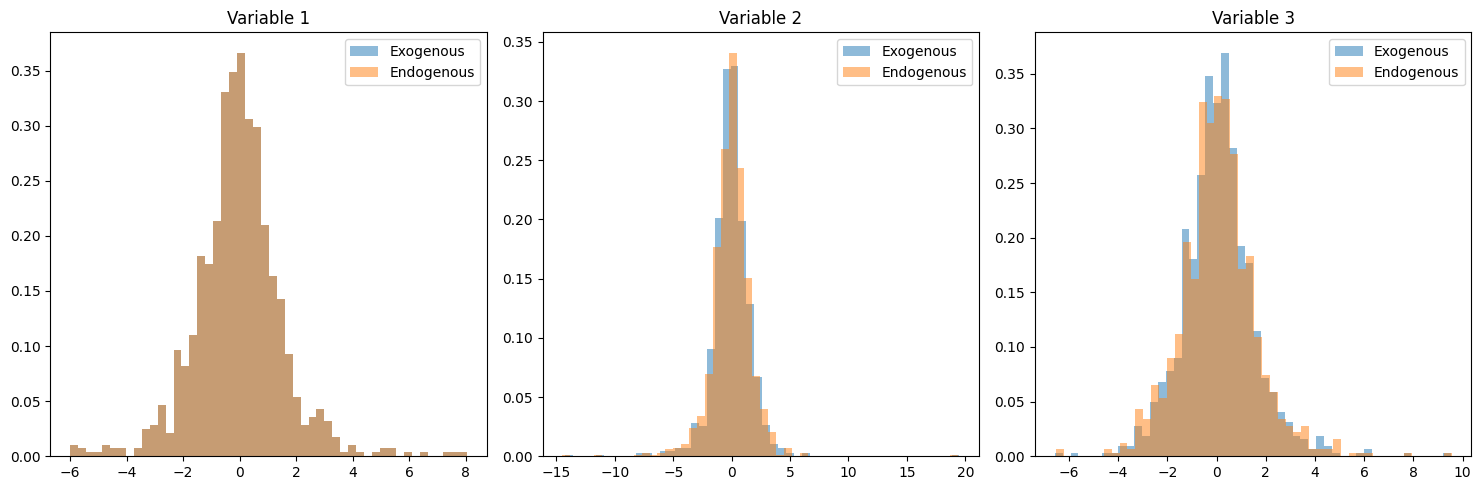

In [115]:
model = lanm.LinearAddSCM(Gll, ll_coeffs, None)
# Generate non-Gaussian exogenous noise
exogenous = generate_non_gaussian_exogenous(
    n_samples=1000,
    n_vars=3,
    distribution_type='multivariate_t',
    params={'scale': 1.0}
)

# Use your existing linear additive mechanism
endogenous = model.sample_settings(exogenous)

# Visualize the results
plot_distributions(exogenous, endogenous)

In [116]:
class DataModifier:
    """
    A class to modify datasets with various types of transformations.
    """
    def __init__(self, data):
        """
        Initialize with original data.
        
        Args:
            data: numpy array of shape (n_samples, n_vars)
        """
        self.original_data = data.copy()
        self.modified_data = data.copy()
        self.n_samples, self.n_vars = data.shape
        
    def reset(self):
        """Reset to original data"""
        self.modified_data = self.original_data.copy()
        return self
        
    def shift_gaussian(self, mean_shift=None, var_multiplier=None):
        """
        Shift Gaussian distribution parameters.
        
        Args:
            mean_shift: dict of shifts for each variable, e.g., {0: 1.5, 2: -0.5}
            var_multiplier: dict of variance multipliers, e.g., {0: 2.0, 2: 0.5}
        """
        if mean_shift:
            for var_idx, shift in mean_shift.items():
                self.modified_data[:, var_idx] += shift
                
        if var_multiplier:
            for var_idx, multiplier in var_multiplier.items():
                mean = np.mean(self.modified_data[:, var_idx])
                self.modified_data[:, var_idx] = (
                    (self.modified_data[:, var_idx] - mean) * 
                    np.sqrt(multiplier) + mean
                )
        return self
    
    def add_non_gaussian_noise(self, distribution_type='exponential', 
                             vars_to_modify=None, params=None):
        """
        Add non-Gaussian noise to specified variables.
        
        Args:
            distribution_type: Type of non-Gaussian noise
            vars_to_modify: List of variable indices to modify
            params: Distribution parameters
        """
        if vars_to_modify is None:
            vars_to_modify = range(self.n_vars)
            
        if params is None:
            params = {}
            
        noise = generate_non_gaussian_exogenous(
            self.n_samples, 
            len(vars_to_modify), 
            distribution_type, 
            params
        )
        
        for idx, var in enumerate(vars_to_modify):
            self.modified_data[:, var] += noise[:, idx]
            
        return self
    
    def contaminate_linearity(self, contamination_fraction=0.3):
        """
        Contaminate linear relationships between variables.
        
        Args:
            contamination_fraction: Fraction of samples to contaminate
        """
        self.modified_data = contaminate_linear_relationships(
            self.modified_data, 
            contamination_fraction
        )
        return self
    
    def add_noise(self, noise_config=None):
        """
        Add various types of noise to make data dirty.
        
        Args:
            noise_config: Dictionary with noise parameters
        """
        self.modified_data = add_noise_to_dataset(
            self.modified_data, 
            noise_config
        )
        return self
    
    def plot_modifications(self):
        """Visualize the changes in the data"""
        # Distribution plots
        plt.figure(figsize=(15, 10))
        
        # Histograms
        for i in range(self.n_vars):
            plt.subplot(2, self.n_vars, i+1)
            plt.hist(self.original_data[:, i], bins=50, alpha=0.5, 
                    label='Original', density=True)
            plt.hist(self.modified_data[:, i], bins=50, alpha=0.5, 
                    label='Modified', density=True)
            plt.title(f'Variable {i+1} Distribution')
            plt.legend()
        
        # Scatter plots
        for i in range(self.n_vars-1):
            plt.subplot(2, self.n_vars-1, self.n_vars+i+1)
            plt.scatter(self.original_data[:, i], self.original_data[:, i+1], 
                       alpha=0.5, s=1, label='Original')
            plt.scatter(self.modified_data[:, i], self.modified_data[:, i+1], 
                       alpha=0.5, s=1, label='Modified')
            plt.xlabel(f'Var {i+1}')
            plt.ylabel(f'Var {i+2}')
            plt.legend()
            
        plt.tight_layout()
        plt.show()

# Example usage:
"""
# Initialize modifier with your data
modifier = DataModifier(data)

# Chain different modifications
modified_data = (modifier
    .shift_gaussian(mean_shift={0: 1.5}, var_multiplier={1: 2.0})
    .add_non_gaussian_noise(distribution_type='exponential', 
                          vars_to_modify=[0, 1])
    .contaminate_linearity(contamination_fraction=0.3)
    .add_noise({
        'gaussian_noise': 0.1,
        'outlier_fraction': 0.01,
        'missing_fraction': 0.05,
        'swap_fraction': 0.02
    })
    .modified_data
)

# Or use step by step
modifier = DataModifier(data)
modifier.shift_gaussian(mean_shift={0: 1.5})
modifier.contaminate_linearity()
modifier.plot_modifications()
"""

"\n# Initialize modifier with your data\nmodifier = DataModifier(data)\n\n# Chain different modifications\nmodified_data = (modifier\n    .shift_gaussian(mean_shift={0: 1.5}, var_multiplier={1: 2.0})\n    .add_non_gaussian_noise(distribution_type='exponential', \n                          vars_to_modify=[0, 1])\n    .contaminate_linearity(contamination_fraction=0.3)\n    .add_noise({\n        'gaussian_noise': 0.1,\n        'outlier_fraction': 0.01,\n        'missing_fraction': 0.05,\n        'swap_fraction': 0.02\n    })\n    .modified_data\n)\n\n# Or use step by step\nmodifier = DataModifier(data)\nmodifier.shift_gaussian(mean_shift={0: 1.5})\nmodifier.contaminate_linearity()\nmodifier.plot_modifications()\n"

ValueError: num must be an integer with 1 <= num <= 4, not 5

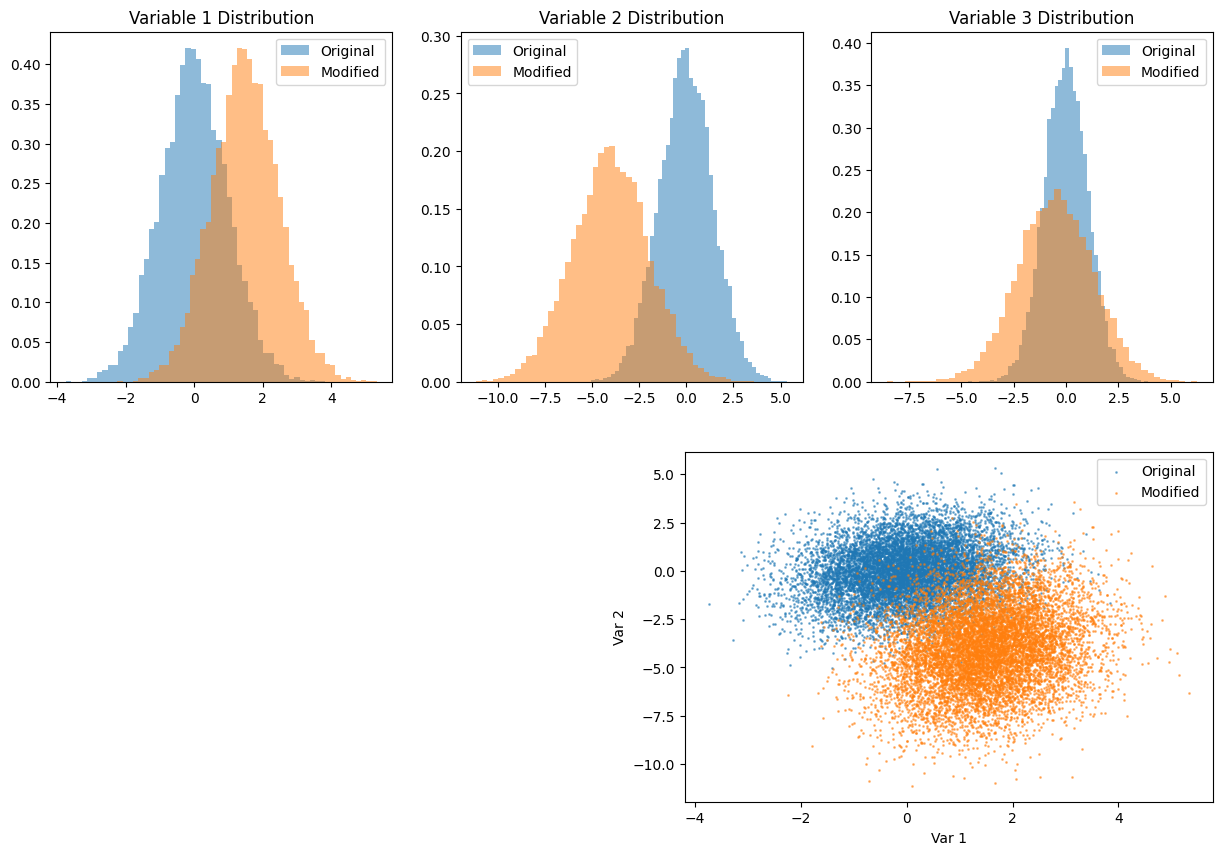

In [121]:
# 1. Just shift Gaussian parameters
modifier = DataModifier(Dll)
shifted_data = modifier.shift_gaussian(
    mean_shift={0: 1.5, 1: -4,2: -0.5},
    var_multiplier={1: 2.0, 2:3}
).modified_data

# # 2. Add non-Gaussian noise to specific variables
# non_gaussian_data = modifier.reset().add_non_gaussian_noise(
#     distribution_type='exponential',
#     vars_to_modify=[0, 2]
# ).modified_data

# # 3. Complex modification
# complex_modification = (modifier.reset()
#     .shift_gaussian(mean_shift={0: 1.0})
#     .add_non_gaussian_noise(distribution_type='exponential')
#     .contaminate_linearity(contamination_fraction=0.3)
#     .modified_data
# )

# 4. Visualize changes
modifier.plot_modifications()

### Run a grid-search

In [41]:
results_dir = f"{experiment}_erica_results"
os.makedirs(results_dir, exist_ok=True)

# Define parameter grids
param_grid = {
    'lambda_param': [0.2, 0.4, 0.6, 0.8, 1.0],
    # Add other hyperparameters here
}

# Fixed parameters
fixed_params = {
    'epsilon': 0.5,
    'delta': 0.5,
    'eta_max': 0.01,
    'eta_min': 0.001,
    'lambda_L': 0.8,
    'lambda_H': 0.8,
    'max_iter': 10,
    'num_steps_min': 1,
    'num_steps_max': 1,
    'tol_max': 1e-4,
    'tol': 1e-4,
    'seed': 42
}

# Generate all combinations of parameters
param_combinations = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]

# Iterate over each combination
for idx, params in enumerate(param_combinations, 1):
    try:
        print(f"Running combination {idx}/{len(param_combinations)}: {params}")

        # Run your optimization function here
        final_mu_L, final_Sigma_L, final_mu_H, final_Sigma_H, final_T = optimize_min_max(
                                                                                        mu_L0, Sigma_L0, mu_H0, Sigma_H0,
                                                                                        LLmodels, HLmodels,
                                                                                        hat_mu_L, hat_Sigma_L, hat_mu_H, hat_Sigma_H,
                                                                                        **params,
                                                                                        **fixed_params
                                                                                        )

        # Prepare results
        results = {
            'parameters': params,
            'mu_L': final_mu_L.detach().numpy(),
            'Sigma_L': final_Sigma_L.detach().numpy(),
            'mu_H': final_mu_H.detach().numpy(),
            'Sigma_H': final_Sigma_H.detach().numpy(),
            'T': final_T.detach().numpy(),
            'execution_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        }

        # Save results
        result_filename = f"{results_dir}/result_{idx}.pkl"
        with open(result_filename, 'wb') as f:
            pickle.dump(results, f)

        print(f"Results saved to: {result_filename}")

    except Exception as e:
        print(f"Error with parameters {params}: {str(e)}")
        continue

Running combination 1/5: {'lambda_param': 0.2}


 30%|███       | 3/10 [00:00<00:00, 25.26it/s]

Step 1/1: Objective = 1.6026020050048828, Gradient Norm = 3.541008710861206
Step 1/1: Objective = 2.157719850540161, Gradient Norm = 3.592430353164673
Step 1/1: Objective = 2.0324082374572754, Gradient Norm = 2.9353740215301514
Step 1/1: Objective = 2.0185794830322266, Gradient Norm = 2.871495246887207
Step 1/1: Objective = 2.0127692222595215, Gradient Norm = 2.8650739192962646


 60%|██████    | 6/10 [00:00<00:00, 18.59it/s]

Step 1/1: Objective = 2.007770538330078, Gradient Norm = 2.8635976314544678
Step 1/1: Objective = 2.00293231010437, Gradient Norm = 2.862715482711792


 80%|████████  | 8/10 [00:00<00:00, 15.00it/s]

Step 1/1: Objective = 1.9981982707977295, Gradient Norm = 2.8620455265045166
Step 1/1: Objective = 1.9935672283172607, Gradient Norm = 2.8615567684173584


100%|██████████| 10/10 [00:00<00:00, 14.12it/s]


Step 1/1: Objective = 1.9890460968017578, Gradient Norm = 2.861253261566162
Final T: tensor([[ 0.3467,  0.1189,  0.2439],
        [ 0.2403, -1.1140, -0.1766]], requires_grad=True)
Final mu_L: tensor([ 0.1181, -0.0881,  0.1137], grad_fn=<AddBackward0>)
Final Sigma_L: tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 1.5633, 0.0000],
        [0.0000, 0.0000, 1.5000]], grad_fn=<AddBackward0>)
Final mu_H: tensor([0.1358, 0.1298], grad_fn=<AddBackward0>)
Final Sigma_H: tensor([[1.5000, 0.0000],
        [0.0000, 1.5000]], grad_fn=<AddBackward0>)
Results saved to: synth1_erica_results/result_1.pkl
Running combination 2/5: {'lambda_param': 0.4}


  0%|          | 0/10 [00:00<?, ?it/s]

Step 1/1: Objective = 1.6026020050048828, Gradient Norm = 3.541008710861206
Step 1/1: Objective = 1.7905457019805908, Gradient Norm = 3.2711431980133057


 40%|████      | 4/10 [00:00<00:00, 26.77it/s]

Step 1/1: Objective = 2.181090831756592, Gradient Norm = 3.886312246322632
Step 1/1: Objective = 1.9982795715332031, Gradient Norm = 2.9500863552093506
Step 1/1: Objective = 1.9930298328399658, Gradient Norm = 2.9484946727752686


 70%|███████   | 7/10 [00:00<00:00, 16.27it/s]

Step 1/1: Objective = 1.9878889322280884, Gradient Norm = 2.9471583366394043
Step 1/1: Objective = 1.9828557968139648, Gradient Norm = 2.946053981781006
Step 1/1: Objective = 1.9779307842254639, Gradient Norm = 2.9451639652252197


 90%|█████████ | 9/10 [00:00<00:00, 13.28it/s]

Step 1/1: Objective = 1.9731204509735107, Gradient Norm = 2.944492816925049


100%|██████████| 10/10 [00:00<00:00, 13.63it/s]


Step 1/1: Objective = 1.9684324264526367, Gradient Norm = 2.9440340995788574
Final T: tensor([[ 0.3466,  0.1188,  0.2443],
        [ 0.2402, -1.1142, -0.1766]], requires_grad=True)
Final mu_L: tensor([ 0.1181, -0.0881,  0.1137], grad_fn=<AddBackward0>)
Final Sigma_L: tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 1.5000, 0.0000],
        [0.0000, 0.0000, 1.5000]], grad_fn=<AddBackward0>)
Final mu_H: tensor([0.1358, 0.1298], grad_fn=<AddBackward0>)
Final Sigma_H: tensor([[1.5000, 0.0000],
        [0.0000, 1.5000]], grad_fn=<AddBackward0>)
Results saved to: synth1_erica_results/result_2.pkl
Running combination 3/5: {'lambda_param': 0.6}


  0%|          | 0/10 [00:00<?, ?it/s]

Step 1/1: Objective = 1.6026020050048828, Gradient Norm = 3.541008710861206
Step 1/1: Objective = 1.5258506536483765, Gradient Norm = 3.138038396835327


 30%|███       | 3/10 [00:00<00:00, 29.34it/s]

Step 1/1: Objective = 1.5836281776428223, Gradient Norm = 3.502628803253174
Step 1/1: Objective = 1.6426475048065186, Gradient Norm = 3.956981897354126
Step 1/1: Objective = 1.697021722793579, Gradient Norm = 4.438928604125977
Step 1/1: Objective = 1.744328498840332, Gradient Norm = 4.839473247528076


 60%|██████    | 6/10 [00:00<00:00, 19.47it/s]

Step 1/1: Objective = 1.78388249874115, Gradient Norm = 5.183915138244629
Step 1/1: Objective = 1.8157119750976562, Gradient Norm = 5.470893859863281


 90%|█████████ | 9/10 [00:00<00:00, 13.90it/s]

Step 1/1: Objective = 1.8403030633926392, Gradient Norm = 5.699570655822754


100%|██████████| 10/10 [00:00<00:00, 13.54it/s]


Step 1/1: Objective = 1.858405351638794, Gradient Norm = 5.874941825866699
Final T: tensor([[ 0.3467,  0.1187,  0.2387],
        [ 0.2405, -1.1128, -0.1763]], requires_grad=True)
Final mu_L: tensor([ 0.1181, -0.0881,  0.1137], grad_fn=<AddBackward0>)
Final Sigma_L: tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 1.5000, 0.0000],
        [0.0000, 0.0000, 1.5000]], grad_fn=<AddBackward0>)
Final mu_H: tensor([0.1359, 0.1298], grad_fn=<AddBackward0>)
Final Sigma_H: tensor([[1.4179, 0.0000],
        [0.0000, 1.4033]], grad_fn=<DiagEmbedBackward0>)
Results saved to: synth1_erica_results/result_3.pkl
Running combination 4/5: {'lambda_param': 0.8}


  0%|          | 0/10 [00:00<?, ?it/s]

Step 1/1: Objective = 1.6026020050048828, Gradient Norm = 3.541008710861206


 30%|███       | 3/10 [00:00<00:00, 29.63it/s]

Step 1/1: Objective = 1.3395202159881592, Gradient Norm = 3.0672192573547363
Step 1/1: Objective = 1.2413148880004883, Gradient Norm = 3.0120716094970703
Step 1/1: Objective = 1.2113540172576904, Gradient Norm = 2.903855323791504
Step 1/1: Objective = 1.202183723449707, Gradient Norm = 2.840022563934326


 60%|██████    | 6/10 [00:00<00:00, 19.13it/s]

Step 1/1: Objective = 1.197507619857788, Gradient Norm = 2.8274905681610107
Step 1/1: Objective = 1.1934016942977905, Gradient Norm = 2.820382833480835
Step 1/1: Objective = 1.1894582509994507, Gradient Norm = 2.813884973526001


 90%|█████████ | 9/10 [00:00<00:00, 13.80it/s]

Step 1/1: Objective = 1.1856379508972168, Gradient Norm = 2.807492971420288


100%|██████████| 10/10 [00:00<00:00, 14.18it/s]


Step 1/1: Objective = 1.1819442510604858, Gradient Norm = 2.801156520843506
Final T: tensor([[ 0.3458,  0.1190,  0.2441],
        [ 0.2401, -1.1129, -0.1766]], requires_grad=True)
Final mu_L: tensor([ 0.1181, -0.0881,  0.1137], grad_fn=<AddBackward0>)
Final Sigma_L: tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 1.5000, 0.0000],
        [0.0000, 0.0000, 0.8770]], grad_fn=<AddBackward0>)
Final mu_H: tensor([0.1358, 0.1298], grad_fn=<AddBackward0>)
Final Sigma_H: tensor([[0.5000, 0.0000],
        [0.0000, 0.5000]], grad_fn=<AddBackward0>)
Results saved to: synth1_erica_results/result_4.pkl
Running combination 5/5: {'lambda_param': 1.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Step 1/1: Objective = 1.6026020050048828, Gradient Norm = 3.541008710861206
Step 1/1: Objective = 1.2434988021850586, Gradient Norm = 2.9818167686462402


 30%|███       | 3/10 [00:00<00:00, 21.89it/s]

Step 1/1: Objective = 1.1818166971206665, Gradient Norm = 2.768096923828125
Step 1/1: Objective = 1.173356294631958, Gradient Norm = 2.735426187515259
Step 1/1: Objective = 1.1689836978912354, Gradient Norm = 2.7261195182800293
Step 1/1: Objective = 1.1651160717010498, Gradient Norm = 2.7191154956817627


 60%|██████    | 6/10 [00:00<00:00, 17.65it/s]

Step 1/1: Objective = 1.1613925695419312, Gradient Norm = 2.71236252784729


 80%|████████  | 8/10 [00:00<00:00, 14.46it/s]

Step 1/1: Objective = 1.157782793045044, Gradient Norm = 2.705651044845581
Step 1/1: Objective = 1.1542861461639404, Gradient Norm = 2.6989614963531494


100%|██████████| 10/10 [00:00<00:00, 13.55it/s]

Step 1/1: Objective = 1.1509135961532593, Gradient Norm = 2.6922953128814697
Final T: tensor([[ 0.3459,  0.1190,  0.2443],
        [ 0.2401, -1.1130, -0.1767]], requires_grad=True)
Final mu_L: tensor([ 0.1181, -0.0881,  0.1137], grad_fn=<AddBackward0>)
Final Sigma_L: tensor([[0.5000, 0.0000, 0.0000],
        [0.0000, 1.5000, 0.0000],
        [0.0000, 0.0000, 0.5837]], grad_fn=<AddBackward0>)
Final mu_H: tensor([0.1358, 0.1298], grad_fn=<AddBackward0>)
Final Sigma_H: tensor([[0.5000, 0.0000],
        [0.0000, 0.5000]], grad_fn=<AddBackward0>)
Results saved to: synth1_erica_results/result_5.pkl


### Load results

In [46]:
with open('synth1_erica_results/result_5.pkl', 'rb') as f:  # Replace with your actual filename
    loaded_results = pickle.load(f)

# Access specific results
print(f"Parameters used:\n{loaded_results['parameters']}")
print(f"T matrix:\n{loaded_results['T']}")
print(f"Execution time: {loaded_results['execution_time']}")

# Access other components as needed:
# loaded_results['mu_L']
# loaded_results['Sigma_L'] 
# loaded_results['mu_H']
# loaded_results['Sigma_H']

Parameters used:
{'lambda_param': 1.0}
T matrix:
[[ 0.34585983  0.11897802  0.24429919]
 [ 0.24009041 -1.1129556  -0.17671084]]
Execution time: 2024-12-03 10:55:55


### Compare results

In [33]:
results_dir = "synth1_erica_results"
result_files = [f for f in os.listdir(results_dir) if f.startswith('result_') and f.endswith('.pkl')]

# Load all results into a list
all_results = []
for filename in result_files:
    with open(os.path.join(results_dir, filename), 'rb') as f:
        result = pickle.load(f)
        all_results.append(result)

# Now you can compare results, find the best parameters, etc.
# For example, if you stored objective values:
best_result = min(all_results, key=lambda x: x.get('objective', float('inf')))
print(f"Best parameters: {best_result['parameters']}")

Best parameters: {'lambda_param': 1.0}


### Find experiments with a specific parameter value

In [39]:
def find_experiments_by_param(results_dir, param_name, param_value):
    # List all result files in the directory
    result_files = [f for f in os.listdir(results_dir) if f.startswith('result_') and f.endswith('.pkl')]
    
    matching_results = []
    
    for filename in result_files:
        with open(os.path.join(results_dir, filename), 'rb') as f:
            result = pickle.load(f)
            # Check if the parameter matches the desired value
            if result['parameters'].get(param_name) == param_value:
                matching_results.append({
                    'filename': filename,
                    'data': result
                })
    
    return matching_results

In [ ]:
# Example usage:
results_dir = "synth1_erica_results"
lambda_param_value = 0.8  # The value you're looking for

matching_experiments = find_experiments_by_param(results_dir, 'lambda_param', lambda_param_value)

if matching_experiments:
    print(f"Found {len(matching_experiments)} experiments with lambda_param = {lambda_param_value}")
    for exp in matching_experiments:
        print(f"\nFilename: {exp['filename']}")
        print(f"Parameters: {exp['data']['parameters']}")
        print(f"Execution time: {exp['data']['execution_time']}")
        # Print other relevant information as needed
        # print(f"T matrix:\n{exp['data']['T']}")
        # print(f"Objective value: {exp['data'].get('objective')}")
else:
    print(f"No experiments found with lambda_param = {lambda_param_value}")

In [76]:
Dhl = torch.from_numpy(Dhl)

TDll = []
for xl in Dll:
    xl = torch.tensor(xl, dtype=torch.float32)

    TDll.append(T @ xl)
TDll = torch.stack(TDll)

# Compute average distance
# Method 1: Using MSE (Mean Squared Error)
mse_distance = torch.mean(torch.sum((TDll - Dhl)**2, dim=1))

# Method 2: Using L2/Euclidean distance
l2_distance = torch.mean(torch.sqrt(torch.sum((TDll - Dhl)**2, dim=1)))

# Method 3: Using L1/Manhattan distance
l1_distance = torch.mean(torch.sum(torch.abs(TDll - Dhl), dim=1))

print(f"MSE Distance: {mse_distance.item()}")
print(f"L2 Distance: {l2_distance.item()}")
print(f"L1 Distance: {l1_distance.item()}")

TypeError: expected np.ndarray (got Tensor)